In [68]:
import json
import xml.etree.ElementTree as ET
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc

In [69]:
conn_str = 'Driver={ODBC Driver 18 for SQL Server};Server=tcp:mia10.database.windows.net,1433;Database=mia10_db;Uid=user_reader;Pwd=7R&o&o4#~756^z;Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'

conn = pyodbc.connect(conn_str)

def fetch_data(conn, query, column_names):
    cursor = conn.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()
    df = pd.DataFrame.from_records(rows, columns=column_names)
    cursor.close()
    return df

queries = {
    'athletes': ('SELECT athlete_id, name, country_id, games_participations, athlete_year_birth FROM athletes', ['athlete_id', 'name', 'country_id', 'games_participations', 'athlete_year_birth']),
    'country': ('SELECT country_name, country_code, country_id FROM country', ['country_name', 'country_code', 'country_id']),
    'events': ('SELECT game_name, game_season, game_year, start_date_str, end_date_str, country_id FROM events', ['game_name', 'game_season', 'game_year', 'start_date_str', 'end_date_str', 'country_id']),
    'medals': ('SELECT discipline_title, slug_game, event_title, event_gender, medal_type, participant_type, athlete_country_id, athlete_id FROM medals', ['discipline_title', 'slug_game', 'event_title', 'event_gender', 'medal_type', 'participant_type', 'athlete_country_id', 'athlete_id'])
}

athletes_df = fetch_data(conn, *queries['athletes'])
country_df = fetch_data(conn, *queries['country'])
hosts_df = fetch_data(conn, *queries['events'])
medals_df = fetch_data(conn, *queries['medals'])

conn.close()

In [70]:
medals = medals_df.merge(country_df, left_on='athlete_country_id', right_on='country_id', how='left')
results_df = medals.merge(athletes_df, on='athlete_id')
results_df['slug_game'] = results_df['slug_game'].str.replace('-', ' ').str.title()
combined_df = results_df.merge(hosts_df, left_on='slug_game', right_on='game_name', how='left')

In [71]:
combined_df

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,athlete_country_id,athlete_id,country_name,country_code,...,name,country_id_y,games_participations,athlete_year_birth,game_name,game_season,game_year,start_date_str,end_date_str,country_id
0,Canoe Sprint,Tokyo 2020,Women's Canoe Double 500m,Women,GOLD,GameTeam,19.0,9,People's Republic of China,CN,...,Shixiao XU,19.0,1,1992.0,Tokyo 2020,Summer,2020.0,2021-07-23 13:00:00,2021-08-08 16:00:00,122.0
1,Canoe Sprint,Tokyo 2020,Women's Canoe Double 500m,Women,GOLD,GameTeam,19.0,10,People's Republic of China,CN,...,Mengya SUN,19.0,1,2001.0,Tokyo 2020,Summer,2020.0,2021-07-23 13:00:00,2021-08-08 16:00:00,122.0
2,Tennis,Rio 2016,doubles women,Women,GOLD,GameTeam,92.0,11,ROC,ROC,...,Elena VESNINA,92.0,4,1986.0,Rio 2016,Summer,2016.0,2016-08-05 14:00:00,2016-08-21 23:00:00,56.0
3,Tennis,Tokyo 2020,Mixed Doubles,Mixed,SILVER,GameTeam,92.0,11,ROC,ROC,...,Elena VESNINA,92.0,4,1986.0,Tokyo 2020,Summer,2020.0,2021-07-23 13:00:00,2021-08-08 16:00:00,122.0
4,Tennis,Tokyo 2020,Mixed Doubles,Mixed,SILVER,GameTeam,92.0,12,ROC,ROC,...,Aslan KARATSEV,92.0,1,1993.0,Tokyo 2020,Summer,2020.0,2021-07-23 13:00:00,2021-08-08 16:00:00,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,Athletics,Athens 1896,800m men,Men,GOLD,Athlete,153.0,11048,MIX,None,...,Edwin FLACK,153.0,1,1873.0,Athens 1896,Summer,1896.0,1896-04-06 11:48:00,1896-04-15 11:49:00,84.0
3445,Athletics,Athens 1896,1500m men,Men,GOLD,Athlete,153.0,11048,MIX,None,...,Edwin FLACK,153.0,1,1873.0,Athens 1896,Summer,1896.0,1896-04-06 11:48:00,1896-04-15 11:49:00,84.0
3446,Tennis,Athens 1896,doubles men,Men,BRONZE,GameTeam,153.0,11049,MIX,None,...,George Stuart ROBERTSON,153.0,1,1872.0,Athens 1896,Summer,1896.0,1896-04-06 11:48:00,1896-04-15 11:49:00,84.0
3447,Tennis,Athens 1896,doubles men,Men,GOLD,GameTeam,153.0,11058,MIX,None,...,John BOLAND,153.0,1,1870.0,Athens 1896,Summer,1896.0,1896-04-06 11:48:00,1896-04-15 11:49:00,84.0


In [72]:
combined_df.columns

Index(['discipline_title', 'slug_game', 'event_title', 'event_gender',
       'medal_type', 'participant_type', 'athlete_country_id', 'athlete_id',
       'country_name', 'country_code', 'country_id_x', 'name', 'country_id_y',
       'games_participations', 'athlete_year_birth', 'game_name',
       'game_season', 'game_year', 'start_date_str', 'end_date_str',
       'country_id'],
      dtype='object')

In [73]:
medals_per_athlete = combined_df.groupby('name')['medal_type'].count()
medals_per_athlete = medals_per_athlete.sort_values(ascending=False)
athlete_games_details = combined_df[['name', 'game_name', 'game_year', 'medal_type']]

In [74]:
medals_per_athlete.head(25)

name
Hao WANG               16
Nan WANG               16
Marit BJOERGEN         12
Fernando GONZALEZ       9
Nan ZHANG               8
Liang TIAN              8
Dmitry SAUTIN           8
Minxia WU               7
Gert FREDRIKSSON        7
Ivan PATZAICHIN         7
Charlotte KALLA         7
Birgit FISCHER          7
Qian LI                 6
Ting LI                 6
Jong Oh JIN             6
Jingjing GUO            6
Vladimir MOROZOV        6
Tao WANG                6
Anna MEARES             6
Lisa CARRINGTON         6
German SANCHEZ          6
Jun ZHANG               6
Ni XIONG                5
Georg HACKL             5
Elana MEYERS TAYLOR     5
Name: medal_type, dtype: int64

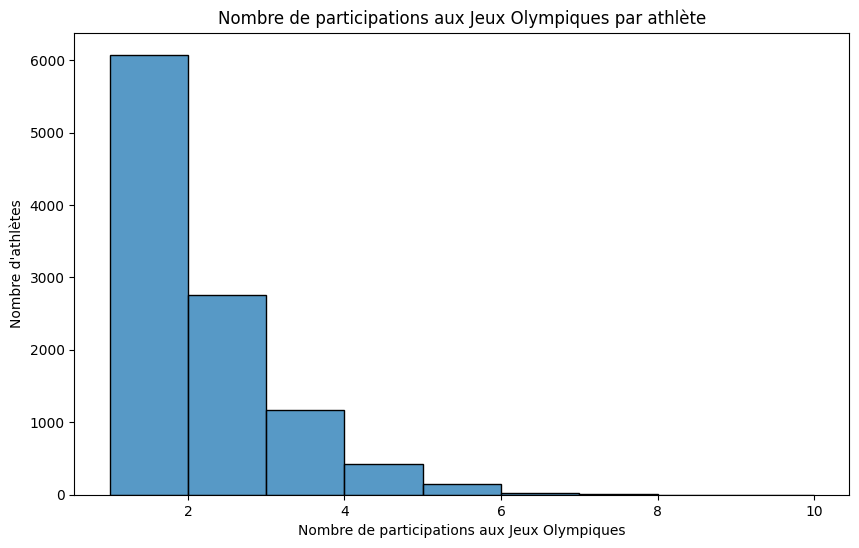

In [75]:
plt.figure(figsize=(10, 6))
sns.histplot(athletes_df['games_participations'], bins=range(1, athletes_df['games_participations'].max() + 2), kde=False)
plt.xlabel('Nombre de participations aux Jeux Olympiques')
plt.ylabel('Nombre d\'athlètes')
plt.title('Nombre de participations aux Jeux Olympiques par athlète')
plt.show()

C:\Users\kirit\AppData\Local\Temp\ipykernel_26176\2797572491.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=medals_count.index, y=medals_count.values, palette='viridis')


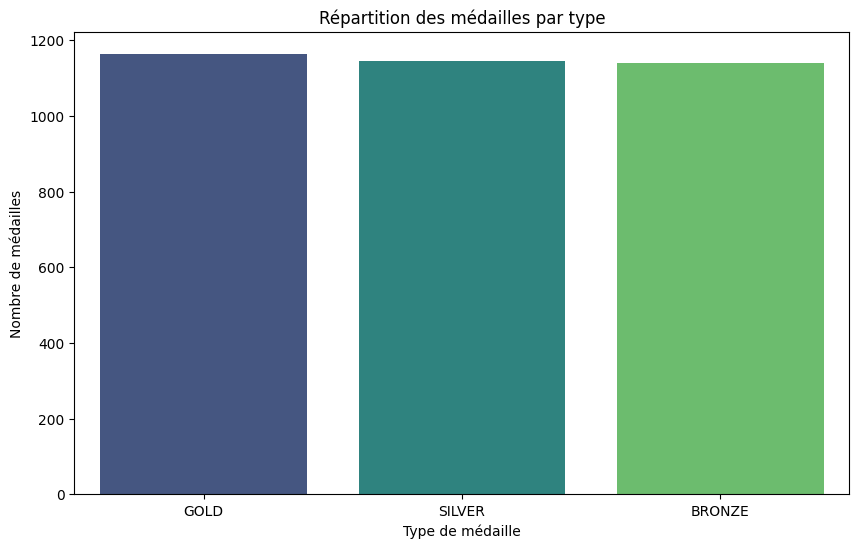

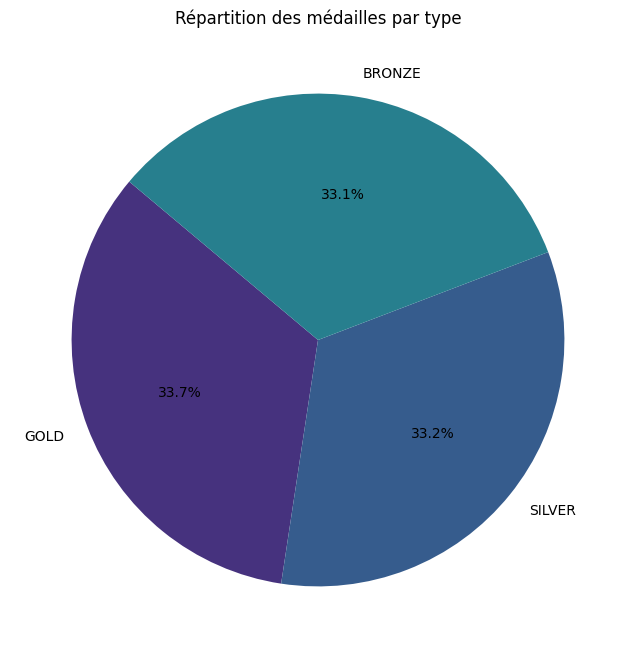

In [76]:
medals_count = combined_df['medal_type'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=medals_count.index, y=medals_count.values, palette='viridis')
plt.xlabel('Type de médaille')
plt.ylabel('Nombre de médailles')
plt.title('Répartition des médailles par type')
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(medals_count, labels=medals_count.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
plt.title('Répartition des médailles par type')
plt.show()

C:\Users\kirit\AppData\Local\Temp\ipykernel_26176\3207787310.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=medals_by_country.values, y=medals_by_country.index, palette='viridis')


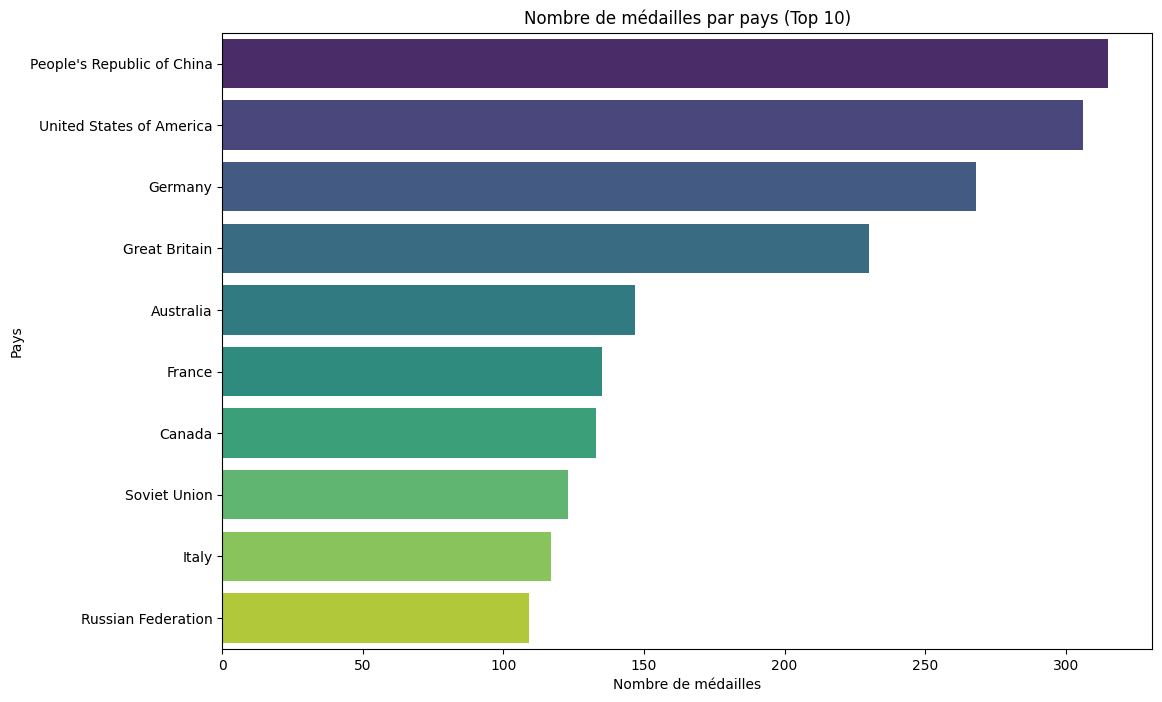

In [77]:
medals_by_country = combined_df['country_name'].value_counts().head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=medals_by_country.values, y=medals_by_country.index, palette='viridis')
plt.xlabel('Nombre de médailles')
plt.ylabel('Pays')
plt.title('Nombre de médailles par pays (Top 10)')
plt.show()

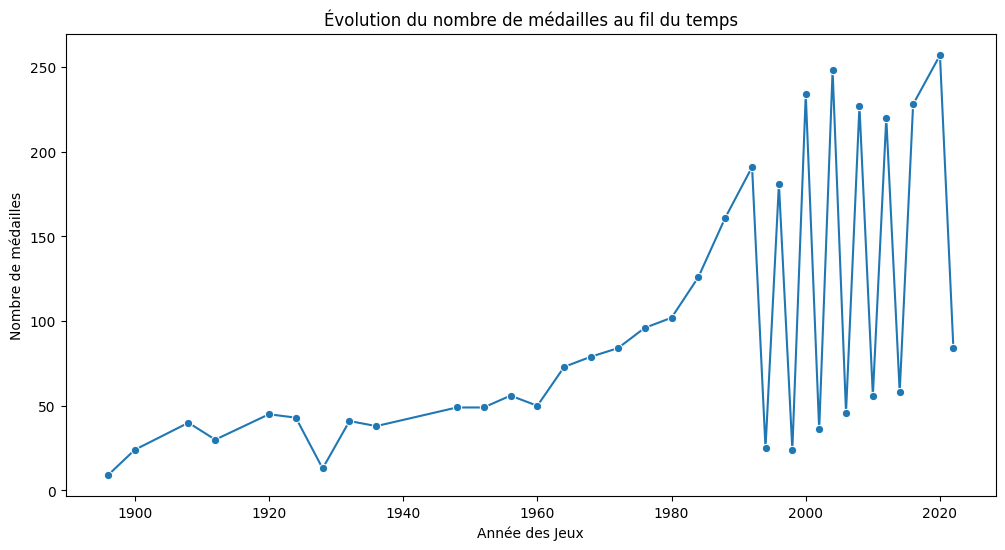

In [78]:
medals_by_year = combined_df.groupby('game_year')['medal_type'].count()

plt.figure(figsize=(12, 6))
sns.lineplot(x=medals_by_year.index, y=medals_by_year.values, marker='o')
plt.xlabel('Année des Jeux')
plt.ylabel('Nombre de médailles')
plt.title('Évolution du nombre de médailles au fil du temps')
plt.show()

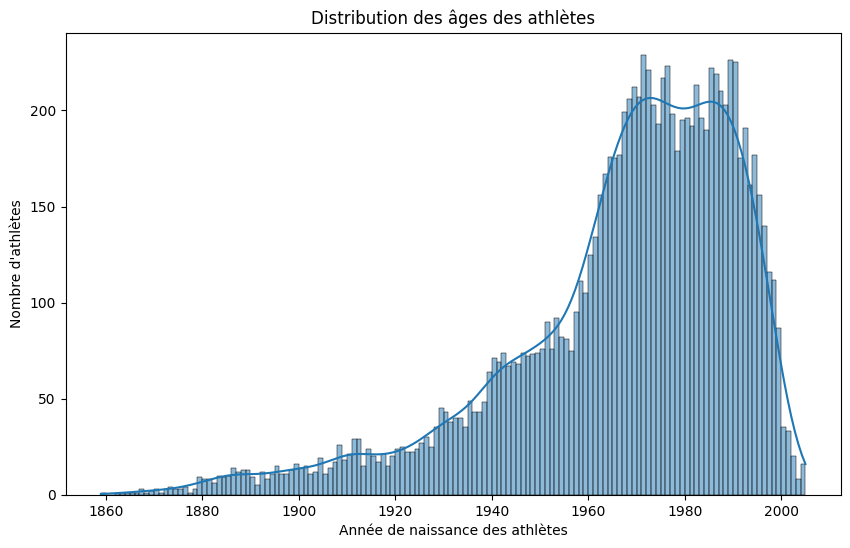

In [79]:
plt.figure(figsize=(10, 6))
sns.histplot(athletes_df['athlete_year_birth'], bins=range(int(athletes_df['athlete_year_birth'].min()), int(athletes_df['athlete_year_birth'].max()) + 1), kde=True)
plt.xlabel('Année de naissance des athlètes')
plt.ylabel('Nombre d\'athlètes')
plt.title('Distribution des âges des athlètes')
plt.show()

C:\Users\kirit\AppData\Local\Temp\ipykernel_26176\289068503.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=age_by_discipline.index, x=age_by_discipline.values, palette='viridis')


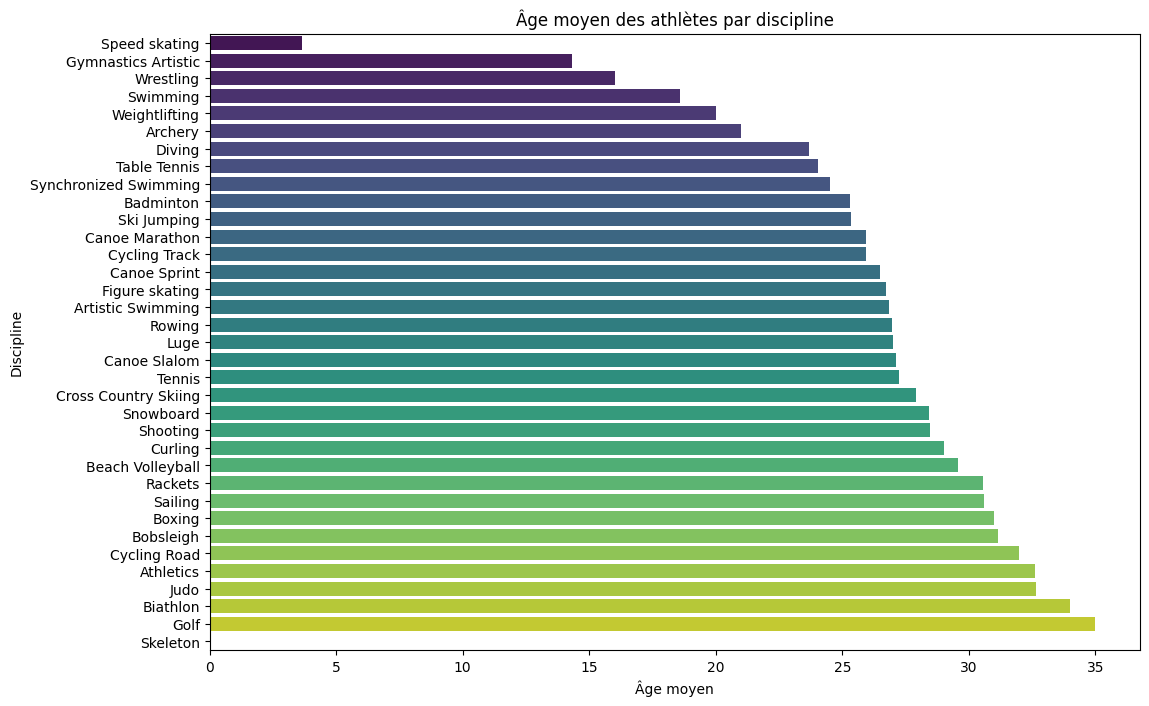

In [80]:
combined_df['age_at_game'] = combined_df['game_year'] - combined_df['athlete_year_birth']

age_by_discipline = combined_df.groupby('discipline_title')['age_at_game'].mean().sort_values()

plt.figure(figsize=(12, 8))
sns.barplot(y=age_by_discipline.index, x=age_by_discipline.values, palette='viridis')
plt.xlabel('Âge moyen')
plt.ylabel('Discipline')
plt.title('Âge moyen des athlètes par discipline')
plt.show()

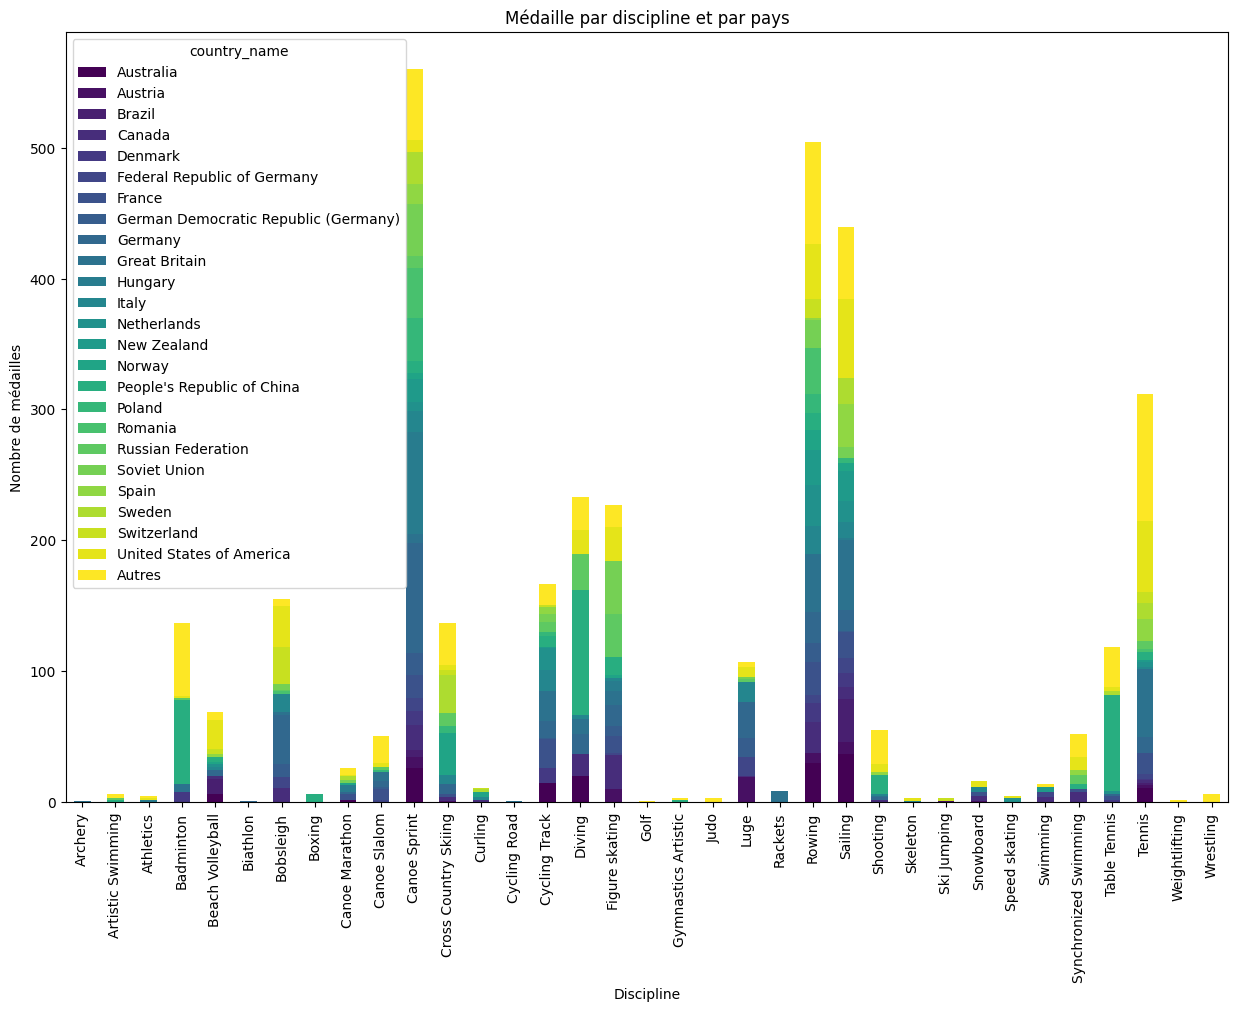

In [81]:
medals_by_discipline_country = combined_df.groupby(['discipline_title', 'country_name'])['medal_type'].count().unstack().fillna(0)
total_medals_by_country = medals_by_discipline_country.sum(axis=0)

threshold = 50
small_countries = total_medals_by_country[total_medals_by_country < threshold].index

medals_by_discipline_country['Autres'] = medals_by_discipline_country[small_countries].sum(axis=1)
medals_by_discipline_country = medals_by_discipline_country.drop(columns=small_countries)

medals_by_discipline_country.plot(kind='bar', stacked=True, figsize=(15, 10), colormap='viridis')
plt.xlabel('Discipline')
plt.ylabel('Nombre de médailles')
plt.title('Médaille par discipline et par pays')
plt.show()

C:\Users\kirit\AppData\Local\Temp\ipykernel_26176\3833766004.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=medals_by_season.index, y=medals_by_season.values, palette='viridis')


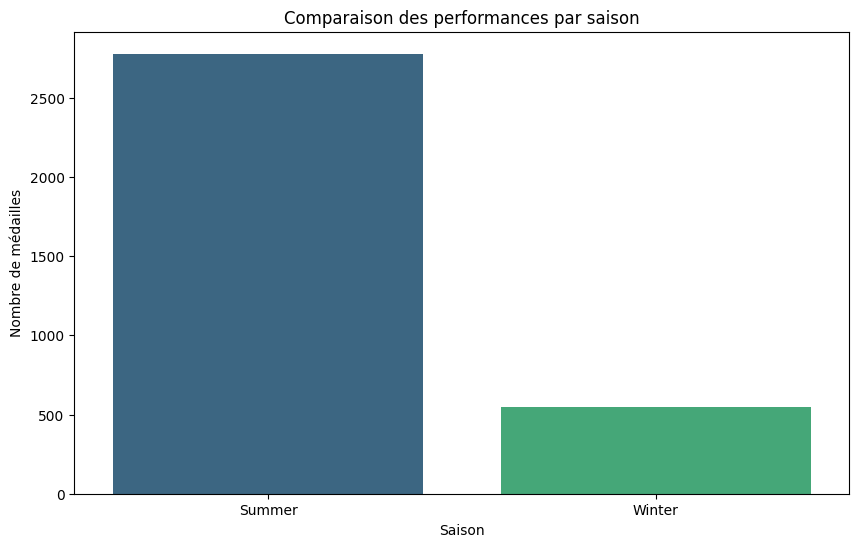

In [82]:
medals_by_season = combined_df.groupby('game_season')['medal_type'].count()

plt.figure(figsize=(10, 6))
sns.barplot(x=medals_by_season.index, y=medals_by_season.values, palette='viridis')
plt.xlabel('Saison')
plt.ylabel('Nombre de médailles')
plt.title('Comparaison des performances par saison')
plt.show()

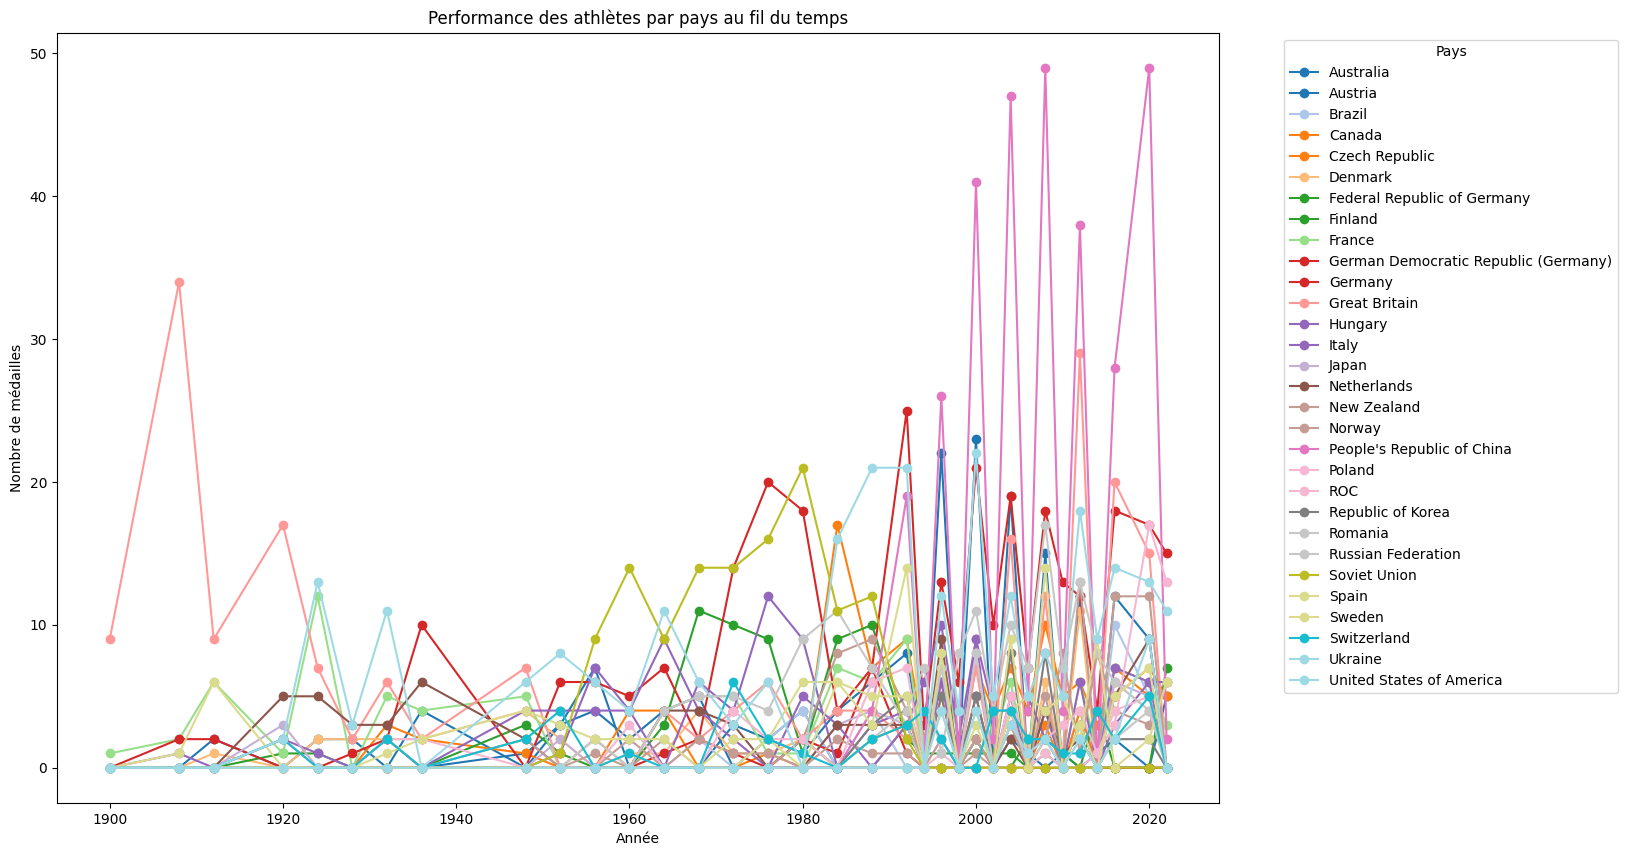

In [88]:
total_medals_by_country = combined_df.groupby('country_name')['medal_type'].count()

threshold = 25
countries_above_threshold = total_medals_by_country[total_medals_by_country > threshold].index
filtered_df = combined_df[combined_df['country_name'].isin(countries_above_threshold)]
medals_by_year_country = filtered_df.groupby(['game_year', 'country_name'])['medal_type'].count().unstack().fillna(0)

plt.figure(figsize=(15, 10))
medals_by_year_country.plot(kind='line', marker='o', colormap='tab20', ax=plt.gca())
plt.xlabel('Année')
plt.ylabel('Nombre de médailles')
plt.title('Performance des athlètes par pays au fil du temps')
plt.legend(title='Pays', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [84]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='games_participations', data=athletes_df, hue='name', palette='viridis', legend=None)
plt.xlabel('Âge des athlètes')
plt.ylabel('Nombre de participations')
plt.title('Corrélation entre l\'âge des athlètes et le nombre de médailles gagnées')
plt.show()

ValueError: Could not interpret value `age` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>